In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statannot import add_stat_annotation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import quick_load_liuzhong_health_check_data, parse_dict_with_default
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"
l_high_lighted_2 = [
    'v000763', 'v9319', 'v000762', 'v002161',
    'HEART.Normal', 'HEART.SinusRhythm', 'HEART.SinusBradycardia', 'HEART.SinusTachycardia',
    'LUNG.GroundGlassOpacity', 'LUNG.SmallNodule', 'LUNG.Nodule', 'LUNG.Normal',
    'v0009', 'v0008', 'v0010', 'v1235',
    'v0023', 'v1970', 'v1164', 'v9046',
    'v9047', 'v9048', 'v9049', 'v9050',
    'v9057', 'v9064', 'v9045', 'v9058',
    'v9059', 'v9060', 'v9061', 'v9062',
    'v9063', 'v9065', 'v9066', 'v9051', 'v9055',
    'v9089', 'v9090', 'v9091', 'v0017',
    'v0045', 'v0022', 'v1162', 'v1940',
    'v1925', 'LIVER.Steatosis', 'v9453', 'v0955',
    'v9461', 'v9462', 'v9464'
]

In [2]:
df_table1plus

variable,birthday,year,month,day,gender,sample_id,v000760,v000761,v002266,v000763,...,v0015,v0016,v0027,v0026,v0032,age,year-month,age_groups,period,period_age
0,1929-10-24,2021,4,29,male,Us5xW1+s4Lu4EedakxAp9MytDz5zZ9ZxXly4MdZJUwt3uA==,156.7,73.1,NaN,65.0,...,12.3,5.7,6.6,8.9,102.0,92,2021-04,>60,Control-2021,Control-2021_>60
3,1934-02-09,2021,6,26,female,hKtSN/NYEJEaJooDpbHzj8ytDz5zYtZxX1G5M9REUwhwtg==,145.0,43.1,NaN,72.0,...,11.0,4.3,6.7,7.0,69.0,87,2021-06,>60,Control-2021,Control-2021_>60
4,1935-08-03,2020,11,17,male,0fbTgXNqwlVXIYdmhOdbnMytDz5zZ9ZxX1C5OdROUg53vg==,NaN,NaN,NaN,65.0,...,4.3,1.2,3.1,2.9,363.0,85,2020-11,>60,Control-2021,Control-2021_>60
5,1936-08-01,2022,11,11,female,1pLKnwZ5bmrFuxkL8d1wGsytDz5zY9ZxX1O5OdRMUgdyvQ==,154.5,60.7,NaN,71.0,...,8.0,2.9,5.1,NaN,70.0,86,2022-11,>60,Test-2023,Test-2023_>60
6,1936-08-18,2021,6,5,female,tGM0i7hHGnDWL/oZ6eGpisytDz5zY9ZxX1O5OdVFUwZ0vA==,146.6,42.3,NaN,84.0,...,6.9,2.8,4.1,4.3,68.0,85,2021-06,>60,Control-2021,Control-2021_>60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235674,2000-11-21,2023,5,18,male,8+3mx/J+Q6OKuhc/U12FFMytDzxxZ9V4XFW4MNZMUwZ1uw==,181.5,85.1,86.0,87.0,...,16.4,4.9,11.5,1.8,88.0,23,2023-05,<30,Test-2023,Test-2023_<30
235676,2001-06-28,2023,2,21,male,Lx1C60ijpMII6pqwVB7nLcytDzt7YtV4XFS5N9ZFUg5xtg==,173.0,72.5,86.0,97.0,...,29.7,8.1,21.6,4.6,88.0,22,2023-02,<30,Test-2023,Test-2023_<30
235677,2001-10-20,2021,1,26,male,QZtN4g8OUo5UK6ludqflEcytDz57YtV4XFS4MdZNUwl3tw==,NaN,NaN,NaN,NaN,...,3.2,1.0,2.2,NaN,90.0,20,2021-01,<30,Control-2021,Control-2021_<30
235678,2003-04-01,2022,11,21,male,paddROeIXmmzCoUdYz5skMqsDTlxadV4XFa5NdRMVwx31g==,169.5,54.9,66.0,77.0,...,15.6,5.9,9.7,3.3,85.0,19,2022-11,<30,Test-2023,Test-2023_<30


# xgboost Training

## feature engineering

In [3]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==0) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

l_t_change_22_23 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==1) & (df_t_change["Test-2023"]==1)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"
sub_2223 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_22_23)]
sub_2223["group"] = "t-abnorm_22-23"

df_t_group = pd.concat([sub_, sub_23, sub_2223])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,birthday,year,month,period,gender,sample_id,v000760,v000761,v002266,v000763,...,v0027,v0026,v0032,age,year-month,age_groups,period_age,group,group_each_year,group_num
54985,1993-05-22,2021,2,Control-2021,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,155.2,53.0,NaN,102.0,...,5.3,4.1,63.0,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
54988,1993-05-22,2022,2,Control-2022,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,94.0,...,5.3,NaN,69.0,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
54991,1993-05-22,2023,2,Test-2023,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,90.0,...,5.9,NaN,63.0,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
34103,1981-11-11,2021,2,Control-2021,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,162.1,70.2,NaN,89.0,...,10.8,NaN,66.0,40,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
34105,1981-11-11,2022,2,Control-2022,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,163.6,69.9,NaN,87.0,...,8.9,NaN,61.0,41,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6674,1957-10-20,2022,1,Control-2022,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,171.0,75.3,NaN,76.0,...,15.5,8.3,101.0,65,2022-01,>60,Control-2022_>60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1
6676,1957-10-20,2023,1,Test-2023,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,170.0,73.7,NaN,91.0,...,9.9,5.9,102.0,66,2023-01,>60,Test-2023_>60,t-abnorm_22-23,t-abnorm_22-23-Test-2023,1
12046,1964-06-30,2021,2,Control-2021,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,168.0,72.7,NaN,73.0,...,7.0,5.9,72.0,57,2021-02,45-60,Control-2021_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2021,1
12048,1964-06-30,2022,2,Control-2022,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,NaN,NaN,NaN,74.0,...,5.6,3.6,73.0,58,2022-02,45-60,Control-2022_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1


## generate xgb input file

In [4]:
# l_core = list(df_meta_group["item_id"])
l_core = l_high_lighted_2
df_23 = pd.DataFrame(df_t_group[df_t_group["period"]=="Test-2023"][l_core].values)
df_22 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2022"][l_core].values)
df_21 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2021"][l_core].values)

eps = 1e-3
col_name = [ parse_dict_with_default(x, rename_dict) for x in l_core ]
df_23_22_d = pd.DataFrame(df_23.values - df_22.values, columns=[f"{x}_23_22_d" for x in col_name])
df_22_21_d = pd.DataFrame(df_22.values - df_21.values, columns=[f"{x}_22_21_d" for x in col_name])
df_23_22_r = pd.DataFrame((df_23.values+eps) / (df_22.values+eps), columns=[f"{x}_23_22_r" for x in col_name])
df_22_21_r = pd.DataFrame((df_22.values+eps) / (df_21.values+eps), columns=[f"{x}_22_21_r" for x in col_name])

df_23.columns = [f"{x}_23" for x in col_name]
df_22.columns = [f"{x}_22" for x in col_name]
df_21.columns = [f"{x}_21" for x in col_name]


df_X = pd.concat([df_23, df_22, df_21, df_23_22_d, df_22_21_d, df_23_22_r, df_22_21_r], axis=1).\
        drop(list(filter(lambda x: x[0:5]=="HEART", df_23.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_d.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_r.columns)), axis=1)

df_X["age"] = [x for x in df_t_group[df_t_group["period"]=="Test-2023"]["age"] ]
df_X["gender"] = [ parse_dict_with_default(x, {"female":0, "male":1}) for x in df_t_group[df_t_group["period"]=="Test-2023"]["gender"] ]

df_Y = df_t_group[df_t_group["period"]=="Test-2023"]["group_num"]

df_X_csv = df_X.copy()
df_X_csv["Y"] = df_Y.values
df_X_csv.to_csv(f"{workdir}/Table_xgboost.csv")


## Training xgb

Train Accuracy: 89.38%


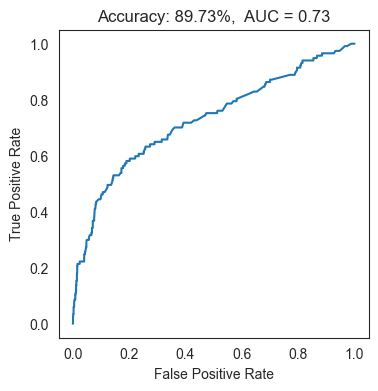

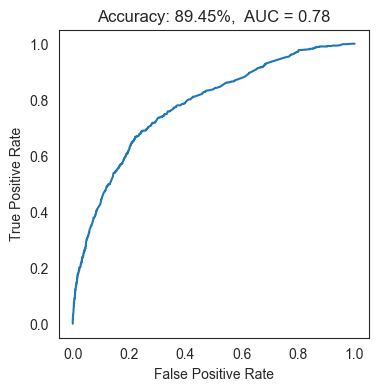

In [5]:

# 预测测试集
model = xgb.XGBClassifier(max_depth=2, min_child_weight=40, gamma=10)

from sklearn.metrics import roc_curve

# 将特征和标签分开
X = df_X.values
y = df_Y.values

# 打乱数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
model.save_model(f"{workdir}/xgb_23Jan-Feb_t-wave.xgb")
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))


# 计算准确性
def plot_roc(X_test, y_test, figsize=(4,4)):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.plot(fpr,tpr)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.set_title("Accuracy: %.2f%%,  AUC = %.2f" % (accuracy*100, auc))
    return fig

fig = plot_roc(X_test, y_test)
fig.savefig(f"{workdir}/Figure3_A.pdf")
fig = plot_roc(X, y)
fig.savefig(f"{workdir}/Figure2_B.pdf")

# interpreting xgboost trees

## get importance

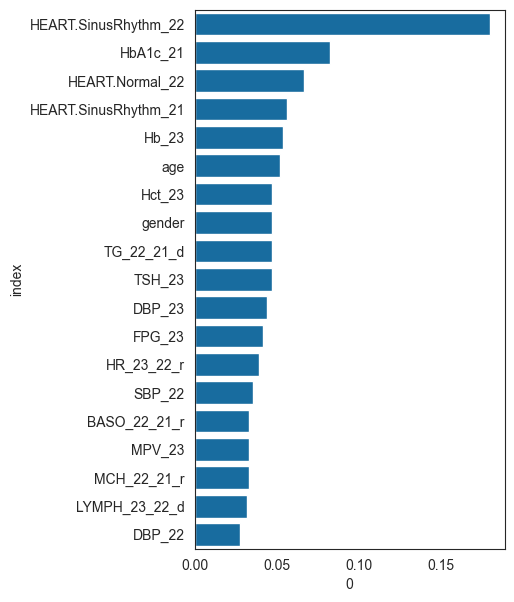

In [6]:
feature_importance = pd.Series(model.feature_importances_, index=df_X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
df_importance = feature_importance[feature_importance>0].reset_index()


fig = plt.figure(figsize=(4,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(data=df_importance, x=0, y="index", ax=ax, color="#0172B6")
fig.savefig(f"{workdir}/Figure3_B.pdf")

## Plot xgb-trees

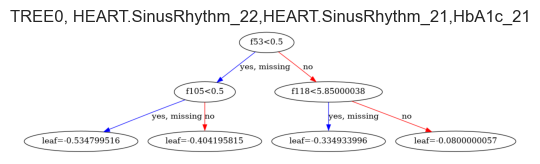

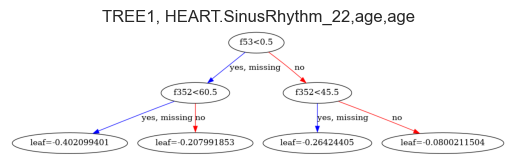

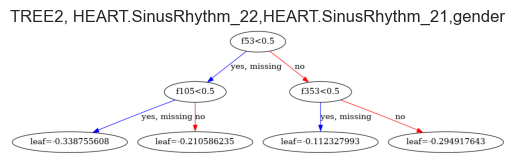

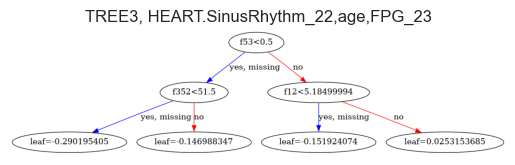

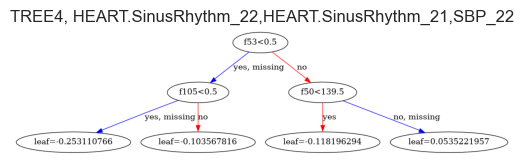

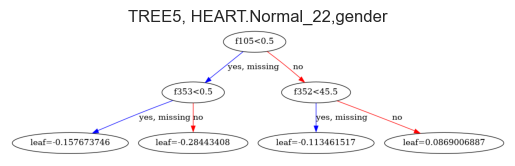

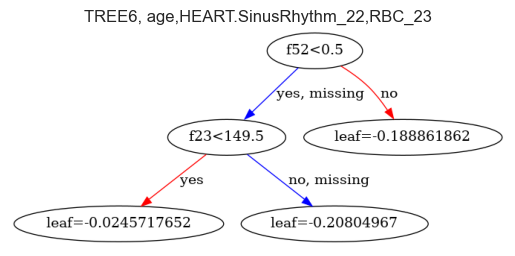

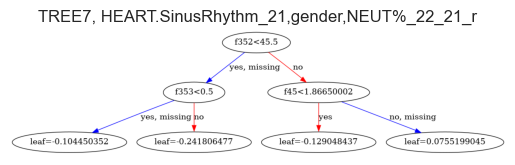

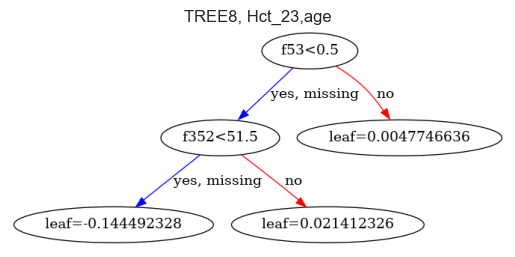

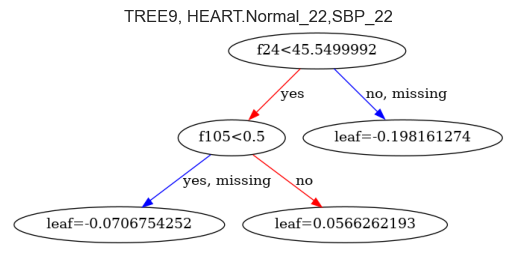

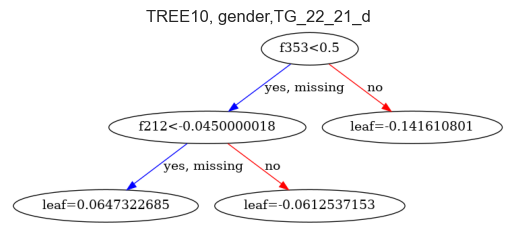

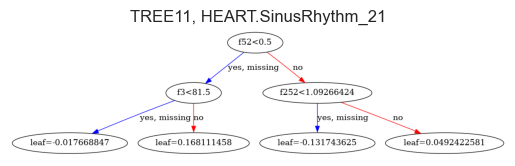

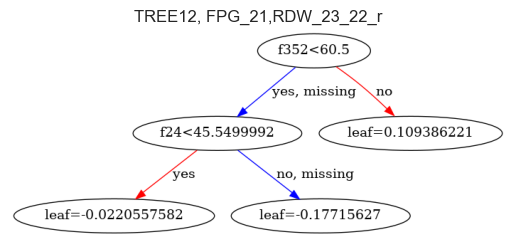

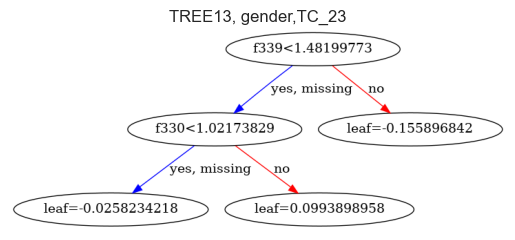

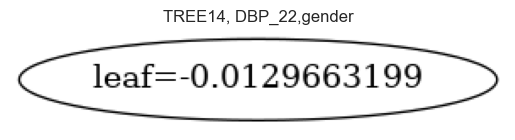

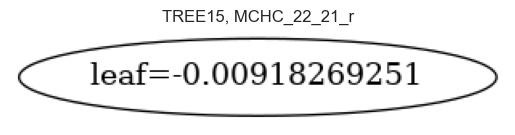

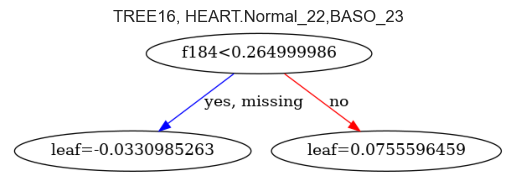

In [7]:
# l_nodes = [
#     [53, 352, 50],
#     [53, 205, 111],
#     [53, 352, 12],
#     [52, 118],
#     [105, 52, 111],
    
#     [52, 353],
#     [352, 53, 20],
#     [105, 353, 319],
#     [24, 352],
#     [52, 50],

#     [353, 212],
#     [105],
#     [116, 280],
#     [353, 9],
#     [51, 353],
    
#     [331],
#     [52, 35],
# ]


l_nodes = [
    [53, 105, 118],
    [53, 352, 352],
    [53, 105, 353],
    [53, 352, 12],
    [53, 105, 50],
    
    [52, 353],
    [352, 53, 20],
    [105, 353, 319],
    [24, 352],
    [52, 50],

    [353, 212],
    [105],
    [116, 280],
    [353, 9],
    [51, 353],
    
    [331],
    [52, 35],
]
for i_tree,nodes in enumerate(l_nodes):
    s_out = ",".join([f"{df_X.columns[x]}" for x in nodes])
    xgb.plot_tree(model, num_trees=i_tree)
    plt.title(f"TREE{i_tree}, {s_out}")
    plt.show()

## df_t_change from discovery above

```python
plt_sankey.plot_sankey_subplots(df_cnt, [1,2], tag, l_age_groups, l_pairs)
```

In [8]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"

df_t_group = pd.concat([sub_, sub_23])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,birthday,year,month,period,gender,sample_id,v000760,v000761,v002266,v000763,...,v0027,v0026,v0032,age,year-month,age_groups,period_age,group,group_each_year,group_num
54985,1993-05-22,2021,2,Control-2021,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,155.2,53.0,NaN,102.0,...,5.3,4.1,63.0,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
54988,1993-05-22,2022,2,Control-2022,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,94.0,...,5.3,NaN,69.0,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
54991,1993-05-22,2023,2,Test-2023,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,90.0,...,5.9,NaN,63.0,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
34103,1981-11-11,2021,2,Control-2021,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,162.1,70.2,NaN,89.0,...,10.8,NaN,66.0,40,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
34105,1981-11-11,2022,2,Control-2022,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,163.6,69.9,NaN,87.0,...,8.9,NaN,61.0,41,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9030,1961-09-30,2022,2,Control-2022,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,NaN,NaN,NaN,58.0,...,8.5,6.6,105.0,61,2022-02,>60,Control-2022_>60,t-abnorm_2023,t-abnorm_2023-Control-2022,1
9033,1961-09-30,2023,2,Test-2023,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,NaN,NaN,NaN,59.0,...,6.9,4.8,98.0,62,2023-02,>60,Test-2023_>60,t-abnorm_2023,t-abnorm_2023-Test-2023,1
54627,1993-02-07,2021,2,Control-2021,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,166.5,69.3,NaN,80.0,...,8.2,3.8,92.0,28,2021-02,<30,Control-2021_<30,t-abnorm_2023,t-abnorm_2023-Control-2021,1
54629,1993-02-07,2022,2,Control-2022,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,168.0,68.9,NaN,67.0,...,8.3,NaN,94.0,29,2022-02,<30,Control-2022_<30,t-abnorm_2023,t-abnorm_2023-Control-2022,1


# interpreting xgboost results via the statistical significance tests

## Boxplot with Pvalue: LYMPH

>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.494e-01 stat=-1.446e+00
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=4.957e-01 stat=-6.815e-01
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.439e-02 stat=-2.455e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=4.377e-02 stat=-2.018e+00
>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=6.194e-01 stat=-4.977e-01
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.526e-01 stat=3.156e-01
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.327e-01 stat=-1.196e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.998e-01 stat=-1.038e+00


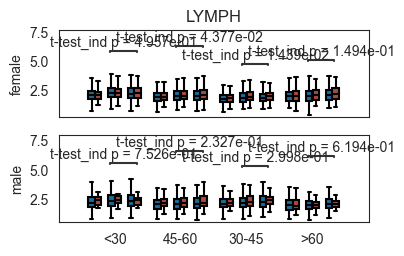

In [9]:
l_tags = [
    'v9057','v9064','v9045','v9058','v9059',
    'v9060','v9061','v9062','v9063','v9065',
    'v9051','v9055','v9089','v9091','v9090',
    'v9046','v9047','v9048','v9049','v9050',
]

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

tag = "v9055"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", #order=l_age_groups,
                hue="group_each_year",y=tag,
                box_pairs=[
                        ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
                        (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
                        (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
                        (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
                ],
                test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    )

fig.savefig(f"{workdir}/Figure5_C.pdf")

## Boxplot with Pvalue: HBP

>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.052e-01 stat=-1.626e+00
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.679e-01 stat=-1.380e+00
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=8.329e-03 stat=-2.649e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.444e-01 stat=3.260e-01
>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=4.745e-01 stat=-7.172e-01
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.735e-01 stat=-1.097e+00
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.506e-01 stat=-1.151e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.711e-04 stat=-3.660e+00


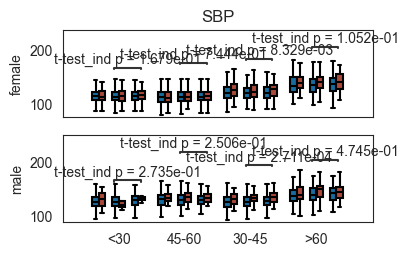

In [10]:
tag = "v000762"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", #order=l_age_groups,
                hue="group_each_year",y=tag,
                box_pairs=[
                        ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
                        (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
                        (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
                        (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
                ],
                test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    )
    
# fig.savefig(f"{workdir}/Figure3_C-1.pdf")

## Barplot with Chi Square Exam, LIVER.Steatosis

In [11]:
def extract_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    np_table = np.zeros([2,2])
    for age in l_age_group_subs:
        arr1 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[0])
        ][tag].dropna().values
        arr2 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[1])
        ][tag].dropna().values
        
        np_table += np.array([
            [arr1.sum(), len(arr1)-arr1.sum()],
            [arr2.sum(), len(arr2)-arr2.sum()],
        ])
    
    return np_table


def print_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, ax=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    ax.axis('tight')
    ax.axis('off')
    np_table = extract_chi2_table(df_t_group, gender, tag, l_age_group_subs, compares)

    chi = scipy.stats.chi2_contingency(np_table)
    np_exp = chi.expected_freq
    list_table = [
        [f"{np_table[0,0]:.0f},({np_exp[0,0]:.2f})", f"{np_table[0,1]:.0f},({np_exp[0,1]:.0f})", f"{np_table[0,0]+np_table[0,1]:.0f}"],
        [f"{np_table[1,0]:.0f},({np_exp[1,0]:.2f})", f"{np_table[1,1]:.0f},({np_exp[1,1]:.0f})", f"{np_table[1,0]+np_table[1,1]:.0f}"],
        [f"{np_table[0,0]+np_table[1,0]:.0f}", f"{np_table[0,1]+np_table[1,1]:.0f}", f"{np_table[0,0]+np_table[1,0]+np_table[1,0]+np_table[1,1]:.0f}"],
    ]
    ax.set_title(f"{l_age_group_subs}, X2 = {chi.pvalue:.2e}")
    the_table = ax.table(cellText=list_table, 
                colLabels=[tag, f"No-{tag}", "rowSum"], 
                rowLabels=["T-wave-Normal", "T-wave-Abnormal", "colSum"],
                edges="open",             
                loc="center"
            )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(7)

<Figure size 800x500 with 0 Axes>

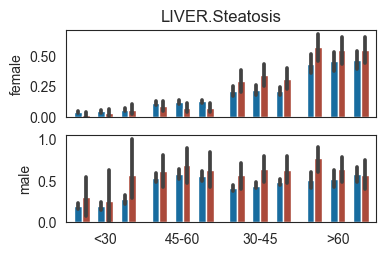

In [12]:
fig = plt.figure(figsize=(8,5))
tag = "LIVER.Steatosis"

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]

idx = 0
gender = "female"

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        
fig.savefig(f"{workdir}/Figure6_B.pdf")

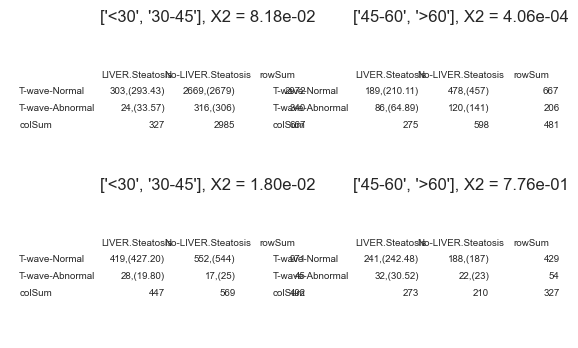

In [13]:
tag = "LIVER.Steatosis"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

fig.savefig(f"{workdir}/Figure6_C.pdf")

## Barplot with Chi Square Exam, LUNG.GroundGlassOpacity in 2022

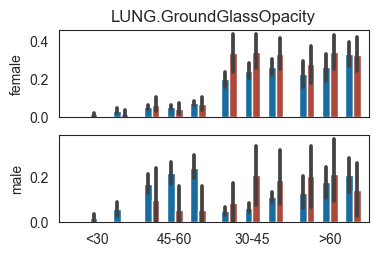

In [14]:

tag = "LUNG.GroundGlassOpacity"

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))

df_t_group[(df_t_group["gender"]==gender)][[tag, "group_num", "age_groups"]].dropna().pivot_table(
    index="group_num", columns="age_groups", aggfunc=len, values=tag
)

fig.savefig(f"{workdir}/Figure4_B.pdf")


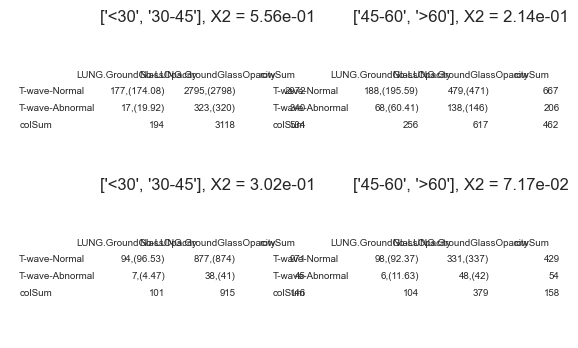

In [15]:

cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]
tag = "LUNG.GroundGlassOpacity"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/FigureS4_A.pdf")


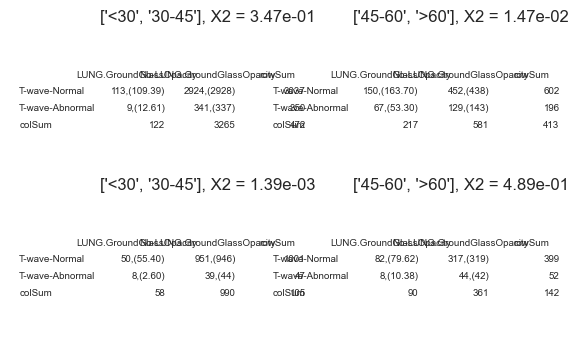

In [16]:
cmp = ["t-norm_2023-Control-2022", "t-abnorm_2023-Control-2022"]
tag = "LUNG.GroundGlassOpacity"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/FigureS4_B.pdf")

## Barplot with Chi Square Exam, is SBP > 139.5

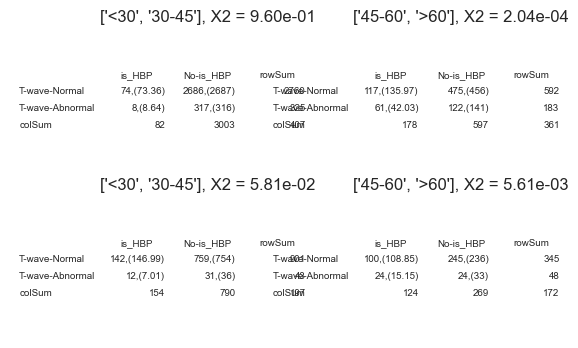

In [17]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBP"] = [1 if x > 139.5 else 0 for x in df_t_group["v000762"]]
df_t_group["is_HBP"][ pd.isna(df_t_group["v000762"]) ] = pd.NA
tag = "is_HBP"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/Figure3_SBP.pdf")

## Barplot with Chi Square Exam, is FBG > 5.6

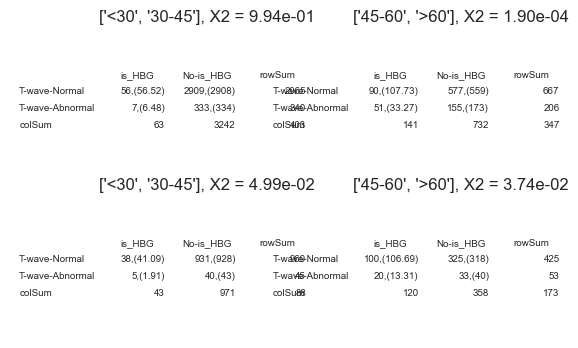

In [18]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBG"] = [1 if x > 5.6 else 0 for x in df_t_group["v0023"]]
df_t_group["is_HBG"][ pd.isna(df_t_group["v0023"]) ] = pd.NA
tag = "is_HBG"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)
fig.savefig(f"{workdir}/Figure3_HBG.pdf")

## Other boxplots

gender                      female                         male                \
age_groups                     <30   30-45  45-60    >60    <30  30-45  45-60   
group_each_year                                                                 
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   34.0   20.0   
t-abnorm_2023-Control-2022   144.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      131.0   209.0  111.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1434.0  1634.0  408.0  152.0  355.0  670.0  264.0   
t-norm_2023-Control-2022    1276.0  1757.0  434.0  167.0  294.0  697.0  290.0   
t-norm_2023-Test-2023       1142.0  1822.0  478.0  188.0  237.0  722.0  305.0   
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   35.0   21.0   
t-abnorm_2023-Control-2022   145.0   205.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      131.0   209.0  111.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1434.0  1635.0  408.0  152.0  358.0  675.0  268.0   
t-norm_2023-Control-2022    1276.0  1758.0  434.0  168.0  298.0  702.0  293.0   
t-norm_2023-Test-2023       1142.0  1823.0  479.0  188.0  242.0  727.0  307.0   
t-abnorm_2023-Control-2021   170.0   182.0   93.0   81.0   12.0   31.0   19.0   
t-abnorm_2023-Control-2022   141.0   192.0   97.0   84.0    8.0   34.0   17.0   
t-abnorm_2023-Test-2023      129.0   196.0   95.0   88.0    7.0   36.0   18.0   
t-norm_2023-Control-2021    1419.0  1526.0  368.0  147.0  353.0  623.0  215.0   
t-norm_2023-Control-2022    1252.0  1617.0  392.0  156.0  292.0  657.0  248.0   
t-norm_2023-Test-2023       1115.0  1645.0  424.0  168.0  237.0  664.0  242.0   
t-abnorm_2023-Control-2021   120.0   179.0   98.0   79.0    9.0   32.0   20.0   
t-abnorm_2023-Control-2022     NaN    25.0   33.0   21.0    1.0   11.0    9.0   
t-abnorm_2023-Test-2023        1.0    22.0   36.0   29.0    2.0    9.0   10.0   
t-norm_2023-Control-2021     908.0  1532.0  393.0  142.0  216.0  602.0  251.0   
t-norm_2023-Control-2022      20.0   175.0  162.0   53.0   14.0  163.0  197.0   
t-norm_2023-Test-2023         12.0   191.0  176.0   61.0    9.0  163.0  209.0   
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   35.0   21.0   
t-abnorm_2023-Control-2022   145.0   205.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      131.0   209.0  111.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1434.0  1635.0  408.0  152.0  358.0  675.0  267.0   
t-norm_2023-Control-2022    1276.0  1758.0  434.0  168.0  298.0  702.0  293.0   
t-norm_2023-Test-2023       1142.0  1823.0  479.0  188.0  242.0  727.0  307.0   
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   145.0   205.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      131.0   209.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1434.0  1636.0  408.0  152.0  358.0  675.0  268.0   
t-norm_2023-Control-2022    1276.0  1758.0  434.0  167.0  298.0  703.0  294.0   
t-norm_2023-Test-2023       1140.0  1823.0  479.0  188.0  242.0  728.0  308.0   
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   145.0   205.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      131.0   209.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1434.0  1636.0  408.0  152.0  358.0  675.0  268.0   
t-norm_2023-Control-2022    1276.0  1758.0  434.0  167.0  298.0  703.0  294.0   
t-norm_2023-Test-2023       1140.0  1823.0  479.0  188.0  242.0  728.0  308.0   
t-abnorm_2023-Control-2021   171.0   190.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   145.0   205.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      131.0   209.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1434.0  1636.0  408.0  152.0  358.0  675.0  268.0   
t-norm_2023-Control-2022    127

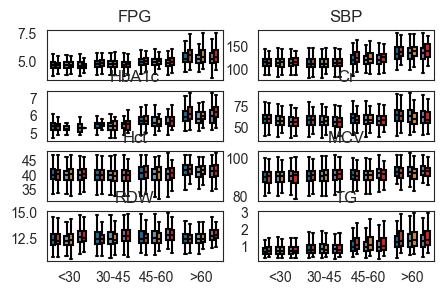

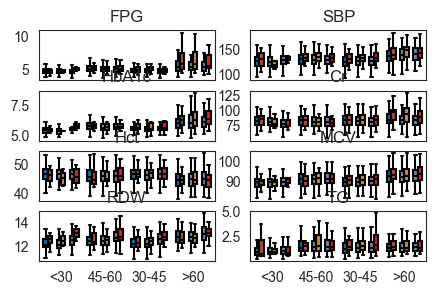

In [19]:
# from utils import parse_dict_with_default
l_orders = [
    "v0023", 'v000762', "v1164", "v0032", 
    "v9059", "v9060", "v9063", "v0009",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#0172B6", "#BD3C29", "#000000",
        "#6F99AD", "#E18727", "#000000",
        "#7876B1", "#FF0000"]

new_cols =  pd.MultiIndex.from_tuples([
            (  'female',   '<30'),        
            (  'female', '30-45'),
            (  'female', '45-60'),
            (  'female',   '>60'),
            (    'male',   '<30'),
            (    'male', '30-45'),
            (    'male', '45-60'),
            (    'male',   '>60'),
            (     'tag',      ''),
            ('tag_name',      '')
])


n_col = 2
l_df_box_n = []
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(5,3))
    for idx,tag in enumerate(l_orders):
        if gender == "male":
            l_df_box_n.append(df_n_boxes)

        ax = fig.add_subplot(4,n_col,1+idx)
        sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                    hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - n_col:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        l_col_used = ["gender", "age_groups", "group_each_year"]
        df_n_boxes = df_t_group[l_col_used + [tag]].dropna()[l_col_used].pivot_table(
                        index="group_each_year", columns=["gender", "age_groups"], aggfunc=len
        )
        df_n_boxes["tag"] = tag
        df_n_boxes["tag_name"] = parse_dict_with_default(tag, rename_dict)
    
    fig.savefig(f"{workdir}/Figure3_C-{gender}.pdf")

df_res = pd.concat(l_df_box_n)
df_res[new_cols]

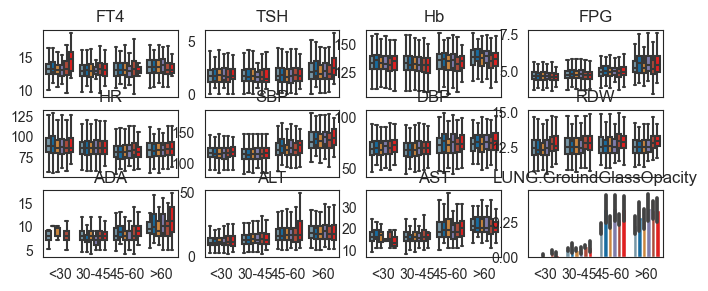

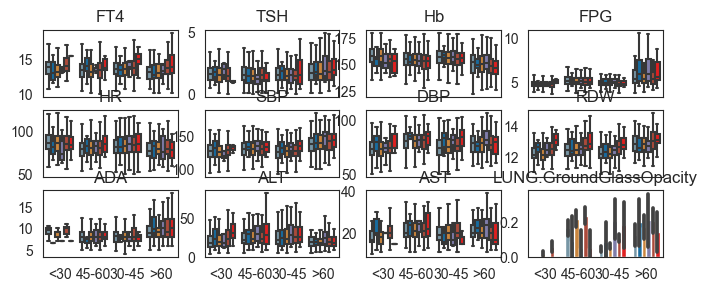

In [20]:
from utils import parse_dict_with_default
l_orders = [
    'v9462', 'v9461', "v9058", "v0023",
    'v000763','v000762', 'v002161', 'v9063',
    "v1162",'v0017', 'v0045', "LUNG.GroundGlassOpacity",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#6F99AD", "#0172B6", "#E18727",  "#7876B1",  "#BD3C29", "#FF0000"]
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(8,4))
    for idx,tag in enumerate(l_orders):
        ax = fig.add_subplot(4,4,1+idx)
        if idx != len(l_orders) -1:
            sns.boxplot(df_t_group[(df_t_group["gender"]==gender)],
                            x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                            hue_order=hue_order, palette=pal, ax=ax)
        else:
            sns.barplot(df_t_group[(df_t_group["gender"]==gender)],
                            x="age_groups", hue="group_each_year", y=tag,
                            hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - 4:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
    # fig.savefig(f"../../analysis/liuzhong/human/clinical/figures/Figure3_why_Tchange-{gender}.pdf")
# fig = plt.figure(figsize=(25,25))
# for idx,tag in enumerate(l_orders):
#     ax = fig.add_subplot(4,4,1+idx)
#     sns.violinplot(df_t_group[df_t_group["gender"]=="male"], x="age_groups", hue="group", y=tag, 
#                 hue_order=["t-norm_2023","t-abnorm_22-23","t-abnorm_2023"], 
#                 palette=["#0172B6", "#E18727", "#BD3C29"], ax=ax
#)
#     ax.set_title(parse_dict_with_default(tag, rename_dict))